# THY Analysis

## Step 1: Data Loading

### Data Reading and Preparation: THY, IATA and Country Data

In [1]:
! hdfs dfs -rm /datasets/thy_raw_data.csv
! hdfs dfs -put ../datasets/thy_data.txt /datasets/thy_raw_data.csv
! hdfs dfs -cat /datasets/thy_raw_data.csv | head -n 10

Deleted /datasets/thy_raw_data.csv
SEASON,ORIGIN,DESTINATION,PSGR_COUNT
SUMMER,227,YYZ,6
SUMMER,224,222,3
SUMMER,226,JF8,1
SUMMER,227,3RG,11
SUMMER,227,6RV,245
SUMMER,222,224,867
SUMMER,226,2DL,2
SUMMER,22E,4UD,12
SUMMER,22E,RUH,16


In [2]:
! hdfs dfs -rm /datasets/iata_icao_raw_data.csv
! hdfs dfs -put ../datasets/iata-icao.csv /datasets/iata_icao_raw_data.csv
! hdfs dfs -cat /datasets/iata_icao_raw_data.csv | head -n 10

Deleted /datasets/iata_icao_raw_data.csv
"country_code","region_name","iata","icao","airport","latitude","longitude"
"AE","Abu Zaby","AAN","OMAL","Al Ain International Airport","24.2617","55.6092"
"AE","Abu Zaby","AUH","OMAA","Abu Dhabi International Airport","24.433","54.6511"
"AE","Abu Zaby","AYM","","Yas Island Seaplane Base","24.467","54.6103"
"AE","Abu Zaby","AZI","OMAD","Al Bateen Executive Airport","24.4283","54.4581"
"AE","Abu Zaby","DHF","OMAM","Al Dhafra Air Base","24.2482","54.5477"
"AE","Abu Zaby","XSB","OMBY","Sir Bani Yas Airport","24.2836","52.5803"
"AE","Abu Zaby","ZDY","OMDL","Dalma Airport","24.51","52.3352"
"AE","Al Fujayrah","FJR","OMFJ","Fujairah International Airport","25.1122","56.324"
"AE","Ash Shariqah","SHJ","OMSJ","Sharjah International Airport","25.3286","55.5172"


In [3]:
! hdfs dfs -rm /datasets/country_raw_data.csv
! hdfs dfs -put ../datasets/country.csv /datasets/country_raw_data.csv
! hdfs dfs -cat /datasets/country_raw_data.csv | head -n 10

Deleted /datasets/country_raw_data.csv
id,value
AF,Afghanistan
AX,"Åland Islands"
AL,Albania
DZ,Algeria
AS,"American Samoa"
AD,Andorra
AO,Angola
AI,Anguilla
AQ,Antarctica


In [4]:
import findspark
findspark.init(spark_home="/usr/local/spark", python_path="/usr/bin/python3")

In [5]:
from pyspark.sql import SparkSession, functions as F, types as T, Window as W
spark = (
    SparkSession.builder
        .appName("THY Analysis")
        .config("spark.driver.memory", "2g")
        .config("spark.executor.memory", "2g")
        .config("spark.executor.cores", "2")
        .config("spark.sql.shuffle.partitions", "8")
        .config("spark.ui.showConsoleProgress", "false")
        .config("spark.sql.warehouse.dir", "/user/hive/warehouse")
        .config("spark.hadoop.hive.metastore.uris", "thrift://localhost:9083")
        .enableHiveSupport()
        .getOrCreate()
)

In [6]:
hive_db = "thy_analysis"
raw_table = "thy_raw_data"
processed_table = "thy_processed_data"

In [7]:
spark.sql(f"CREATE DATABASE IF NOT EXISTS {hive_db}")
spark.sql(f"USE {hive_db}")

In [8]:
df_thy = (
    spark.read.format("csv")
        .option("header", True)
        .option("sep", ",")
        .schema(T.StructType([
            T.StructField("SEASON", T.StringType()),
            T.StructField("ORIGIN", T.StringType()),
            T.StructField("DESTINATION", T.StringType()),
            T.StructField("PSGR_COUNT", T.IntegerType())
        ]))
        .load("/datasets/thy_raw_data.csv")
        .withColumnRenamed("DESTINATION", "DEST")
        .persist()
)

df_iata = (
    spark.read.format("csv")
        .option("header", True)
        .option("sep", ",")
        .schema(T.StructType([
            T.StructField("country_code", T.StringType()),
            T.StructField("region_name", T.StringType()),
            T.StructField("iata", T.StringType()),
            T.StructField("icao", T.StringType()),
            T.StructField("airport", T.StringType()),
            T.StructField("latitude", T.DoubleType()),
            T.StructField("longitude", T.DoubleType())
        ]))
        .load("/datasets/iata_icao_raw_data.csv")
        .withColumnRenamed("country_code", "CNT_CODE")
        .withColumnRenamed("region_name", "REG_NAME")
        .withColumnRenamed("iata", "IATA")
        .withColumnRenamed("icao", "ICAO")
        .withColumnRenamed("airport", "AIR_NAME")
        .withColumnRenamed("latitude", "LAT")
        .withColumnRenamed("longitude", "LON")
        .persist()
)

df_country = (
    spark.read.format("csv")
        .option("header", True)
        .option("sep", ",")
        .schema(T.StructType([
            T.StructField("id", T.StringType()),
            T.StructField("value", T.StringType())
        ]))
        .load("/datasets/country_raw_data.csv")
        .withColumnRenamed("id", "CNT_CODE")
        .withColumnRenamed("value", "CNT_NAME")
        .persist()
)

### Data Merging: Integration of THY, IATA and Country Data

In [9]:
df = df_thy.join(
    df_iata.alias("ORIGIN"), F.col("ORIGIN") == F.col("ORIGIN.IATA"), how="left"
).select(
    df_thy["*"],
    F.col("ORIGIN.CNT_CODE").alias("ORIGIN_CNT_CODE"),
    F.col("ORIGIN.REG_NAME").alias("ORIGIN_REG_NAME"),
    F.col("ORIGIN.AIR_NAME").alias("ORIGIN_AIR_NAME"),
    F.col("ORIGIN.LAT").alias("ORIGIN_LAT"),
    F.col("ORIGIN.LON").alias("ORIGIN_LON")
)

df = df.join(
    df_iata.alias("DEST"), F.col("DEST") == F.col("DEST.IATA"), how="left"
).select(
    df["*"],
    F.col("DEST.CNT_CODE").alias("DEST_CNT_CODE"),
    F.col("DEST.REG_NAME").alias("DEST_REG_NAME"),
    F.col("DEST.AIR_NAME").alias("DEST_AIR_NAME"),
    F.col("DEST.LAT").alias("DEST_LAT"),
    F.col("DEST.LON").alias("DEST_LON")
)

df = df.join(
    df_country.alias("ORIGIN_CNT"), F.col("ORIGIN_CNT_CODE") == F.col("ORIGIN_CNT.CNT_CODE"), how="left"
).select(
    df["*"],
    F.col("ORIGIN_CNT.CNT_NAME").alias("ORIGIN_CNT_NAME")
)

df = df.join(
    df_country.alias("DEST_CNT"), F.col("DEST_CNT_CODE") == F.col("DEST_CNT.CNT_CODE"), how="left"
).select(
    df["*"],
    F.col("DEST_CNT.CNT_NAME").alias("DEST_CNT_NAME")
)

In [10]:
df.repartition(12).write.mode("overwrite").saveAsTable(f"{hive_db}.{raw_table}")

### Data Analysis: Structure, Summary Statistics and Missing Data Check

In [11]:
df.printSchema()

root
 |-- SEASON: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- PSGR_COUNT: integer (nullable = true)
 |-- ORIGIN_CNT_CODE: string (nullable = true)
 |-- ORIGIN_REG_NAME: string (nullable = true)
 |-- ORIGIN_AIR_NAME: string (nullable = true)
 |-- ORIGIN_LAT: double (nullable = true)
 |-- ORIGIN_LON: double (nullable = true)
 |-- DEST_CNT_CODE: string (nullable = true)
 |-- DEST_REG_NAME: string (nullable = true)
 |-- DEST_AIR_NAME: string (nullable = true)
 |-- DEST_LAT: double (nullable = true)
 |-- DEST_LON: double (nullable = true)
 |-- ORIGIN_CNT_NAME: string (nullable = true)
 |-- DEST_CNT_NAME: string (nullable = true)



In [12]:
df.count()

1719202

In [13]:
df.limit(5).toPandas()

,SEASON,ORIGIN,DEST,PSGR_COUNT,ORIGIN_CNT_CODE,ORIGIN_REG_NAME,ORIGIN_AIR_NAME,ORIGIN_LAT,ORIGIN_LON,DEST_CNT_CODE,DEST_REG_NAME,DEST_AIR_NAME,DEST_LAT,DEST_LON,ORIGIN_CNT_NAME,DEST_CNT_NAME
0,SUMMER,227,YYZ,6,None,None,None,NaN,NaN,CA,Ontario,Toronto Pearson International Airport,43.6797,-79.6227,None,Canada
1,SUMMER,224,222,3,None,None,None,NaN,NaN,None,None,None,NaN,NaN,None,None
2,SUMMER,226,JF8,1,None,None,None,NaN,NaN,None,None,None,NaN,NaN,None,None
3,SUMMER,227,3RG,11,None,None,None,NaN,NaN,None,None,None,NaN,NaN,None,None
4,SUMMER,227,6RV,245,None,None,None,NaN,NaN,None,None,None,NaN,NaN,None,None


In [14]:
df.select("SEASON").distinct().show()

+------+
|SEASON|
+------+
|SUMMER|
|WINTER|
+------+



In [15]:
df.select("ORIGIN").distinct().count()

4210

In [16]:
df.select("DEST").distinct().count()

4300

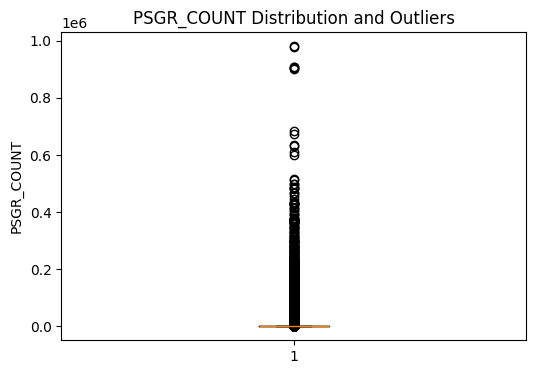

0

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.boxplot(df.select("PSGR_COUNT").toPandas()["PSGR_COUNT"])
plt.title("PSGR_COUNT Distribution and Outliers")
plt.ylabel("PSGR_COUNT")
plt.show()

df.filter(F.col("PSGR_COUNT") <= 0).count()

In [18]:
for column in df.columns:
    missing_count = df.where(F.col(column).isNull()).count()
    print(f"{column} missing value counts: {missing_count}")

SEASON missing value counts: 0
ORIGIN missing value counts: 0
DEST missing value counts: 0
PSGR_COUNT missing value counts: 0
ORIGIN_CNT_CODE missing value counts: 1194292
ORIGIN_REG_NAME missing value counts: 1194292
ORIGIN_AIR_NAME missing value counts: 1194292
ORIGIN_LAT missing value counts: 1194292
ORIGIN_LON missing value counts: 1194292
DEST_CNT_CODE missing value counts: 1194061
DEST_REG_NAME missing value counts: 1194061
DEST_AIR_NAME missing value counts: 1194061
DEST_LAT missing value counts: 1194061
DEST_LON missing value counts: 1194061
ORIGIN_CNT_NAME missing value counts: 1194292
DEST_CNT_NAME missing value counts: 1194061


## Step 2: Data Cleaning

The following code checks whether the values in the `ORIGIN` and `DEST` columns consist of three uppercase letters. It labels valid entries as `1` in the `VALID_ORIGIN` and `VALID_DEST` columns and others as `0`. Then, rows with only valid `ORIGIN` and `DEST` values are filtered, the `VALID_ORIGIN` and `VALID_DEST` columns are dropped from the dataframe.

In [19]:
df_processed = (df
    .withColumn("VALID_ORIGIN", F.when(F.col("ORIGIN").rlike("[A-Z]{3}"), 1).otherwise(0))
    .withColumn("VALID_DEST", F.when(F.col("DEST").rlike("[A-Z]{3}"), 1).otherwise(0))
    .filter((F.col("VALID_ORIGIN") == 1) & (F.col("VALID_DEST") == 1))
    .drop("VALID_ORIGIN", "VALID_DEST")
)

The following code filters out rows with null values in the `ORIGIN_CNT_CODE` and `DEST_CNT_CODE` columns. In other words, only the rows with valid values in both columns remain in the dataframe.

In [20]:
df_processed = df_processed.filter(
    F.col("ORIGIN_CNT_CODE").isNotNull() & F.col("DEST_CNT_CODE").isNotNull()
)

The following code checks whether the values in the `ORIGIN_LAT`, `ORIGIN_LON`, `DEST_LAT`, `DEST_LON` columns fall within valid geographic coordinate ranges. Values between `-90` and `90` for `ORIGIN_LAT` and `DEST_LAT`, values between `-180` and `180` for `ORIGIN_LON` and `DEST_LON` are selected, rows with valid coordinates remain in the dataframe.

In [21]:
df_processed = df_processed.filter(
    (F.col("ORIGIN_LAT").between(-90, 90)) & 
    (F.col("ORIGIN_LON").between(-180, 180)) &
    (F.col("DEST_LAT").between(-90, 90)) &
    (F.col("DEST_LON").between(-180, 180))
)

The following code filters out the outliers in the `PSGR_COUNT` column based on the interquartile range (IQR). First, the 1st quartile (`Q1`) and 3rd quartile (`Q3`) values for `PSGR_COUNT` are calculated, then the `IQR` (`Q3 - Q1`) is determined. Outliers are defined as values outside the range of `Q1 - 1.5 * IQR` and `Q3 + 1.5 * IQR`, these outliers are filtered out and removed from the dataframe.

In [22]:
quantiles = df_processed.approxQuantile("PSGR_COUNT", [0.25, 0.75], 0.05)
Q1, Q3 = quantiles[0], quantiles[1]
IQR = Q3 - Q1
LOWER_BOUND = Q1 - 1.5 * IQR
UPPER_BOUND = Q3 + 1.5 * IQR

df_processed = df_processed.filter(
    (df_processed["PSGR_COUNT"] >= LOWER_BOUND) & (df_processed["PSGR_COUNT"] <= UPPER_BOUND)
)

## Step 3: Feature Engineering

The following code classifies the latitude values in the `ORIGIN_LAT` and `DEST_LAT` columns as `NORTH`, `SOUTH`, or `EQUATOR`, then combines them to create the `ROUTE_HEM` column. Finally, the temporary `ORIGIN_HEM` and `DEST_HEM` columns are removed from the dataframe.

In [23]:
df_processed = (df_processed
    .withColumn("ORIGIN_HEM", F.when(
        F.col("ORIGIN_LAT") > 0, "NORTH").when(F.col("ORIGIN_LAT") < 0, "SOUTH").otherwise("EQUATOR"))
    .withColumn("DEST_HEM", F.when(
        F.col("DEST_LAT") > 0, "NORTH").when(F.col("DEST_LAT") < 0, "SOUTH").otherwise("EQUATOR"))
    .withColumn("ROUTE_HEM", F.concat(F.col("ORIGIN_HEM"), F.lit("→"), F.col("DEST_HEM")))
    .drop("ORIGIN_HEM", "DEST_HEM")
)

The following code combines the values in the `ORIGIN` and `DEST` columns to create the `ROUTE` column. This new column contains route information with the two values joined by the `→` symbol.

In [24]:
df_processed = (df_processed
    .withColumn("ROUTE", F.concat(F.col("ORIGIN"), F.lit("→"), F.col("DEST")))
)

The following code calculates the distance between the `ORIGIN_LAT`, `ORIGIN_LON`, `DEST_LAT`, `DEST_LON` columns using the Haversine formula and stores it in the `ROUTE_DST` column. This calculation returns the great-circle distance between the two points in kilometers. Finally, the temporary `ORIGIN_LAT`, `ORIGIN_LON`, `DEST_LAT`, `DEST_LON` columns are removed from the dataframe.

In [25]:
R = 6371  

df_processed = df_processed.withColumn(
    "ROUTE_DST",
    R * 2 * F.atan2(
        F.sqrt(
            F.sin(F.radians(F.col("DEST_LAT") - F.col("ORIGIN_LAT")) / 2) ** 2 +
            F.cos(F.radians(F.col("ORIGIN_LAT"))) *
            F.cos(F.radians(F.col("DEST_LAT"))) *
            F.sin(F.radians(F.col("DEST_LON") - F.col("ORIGIN_LON")) / 2) ** 2
        ),
        F.sqrt(1 - (
            F.sin(F.radians(F.col("DEST_LAT") - F.col("ORIGIN_LAT")) / 2) ** 2 +
            F.cos(F.radians(F.col("ORIGIN_LAT"))) *
            F.cos(F.radians(F.col("DEST_LAT"))) *
            F.sin(F.radians(F.col("DEST_LON") - F.col("ORIGIN_LON")) / 2) ** 2
        ))
    )
).drop("ORIGIN_LAT", "ORIGIN_LON", "DEST_LAT", "DEST_LON")

The following code determines the flight type based on the country codes in the `ORIGIN_CNT_CODE` and `DEST_CNT_CODE` columns. If both codes are `TR`, the flight type is assigned as `DOMESTIC`; otherwise, it is assigned as `INTERNATIONAL`. This value is stored in the `FLIGHT_TYPE` column.

In [26]:
df_processed = (df_processed
    .withColumn("FLIGHT_TYPE", F.when(
        (F.col("ORIGIN_CNT_CODE") == "TR") & (F.col("DEST_CNT_CODE") == "TR"), "DOMESTIC"
    ).otherwise("INTERNATIONAL"))
)

The following code divides the `PSGR_COUNT` column into three categories: `LOW`, `MEDIUM`, `HIGH`, based on the minimum and maximum values in the column. These categories are determined based on the range between the minimum and maximum values, each flight's passenger count is labeled with one of these categories. These labels are stored in the `PSGR_COUNT_CAT` column.

In [27]:
MIN_PSGR_COUNT = df_processed.agg({"PSGR_COUNT": "min"}).collect()[0][0]
MAX_PSGR_COUNT = df_processed.agg({"PSGR_COUNT": "max"}).collect()[0][0]
RANGE_PSGR = MAX_PSGR_COUNT - MIN_PSGR_COUNT

df_processed = df_processed.withColumn(
    "PSGR_COUNT_CAT",
    F.when(F.col("PSGR_COUNT") <= (MIN_PSGR_COUNT + RANGE_PSGR / 3), "LOW")
    .when((F.col("PSGR_COUNT") > (MIN_PSGR_COUNT + RANGE_PSGR / 3)) & (F.col("PSGR_COUNT") <= (MIN_PSGR_COUNT + 2 * RANGE_PSGR / 3)), "MEDIUM")
    .otherwise("HIGH")
)

The following code divides the `ROUTE_DST` column into three categories: `SHORT`, `MEDIUM`, `LONG`, based on the minimum and maximum distance values. These categories are determined based on the range between the minimum and maximum distances, each route's distance is labeled with one of these categories. These labels are stored in the `ROUTE_DST_BKT` column.

In [28]:
MIN_DST = df_processed.agg({"ROUTE_DST": "min"}).collect()[0][0]
MAX_DST = df_processed.agg({"ROUTE_DST": "max"}).collect()[0][0]
RANGE_DST = MAX_DST - MIN_DST

df_processed = df_processed.withColumn(
    "ROUTE_DST_BKT",
    F.when(F.col("ROUTE_DST") <= (MIN_DST + RANGE_DST / 3), "SHORT")
    .when((F.col("ROUTE_DST") > (MIN_DST + RANGE_DST / 3)) & (F.col("ROUTE_DST") <= (MIN_DST + 2 * RANGE_DST / 3)), "MEDIUM")
    .otherwise("LONG")
)

The following code combines the values in the `SEASON`, `PSGR_COUNT_CAT`, `ROUTE_DST_BKT` columns to create the `FLIGHT_SEG` column. This new column labels each flight with the season, passenger count category, route distance category, using the `_` symbol to separate the labels.

In [29]:
df_processed = (df_processed
    .withColumn("FLIGHT_SEG", F.concat(F.col("SEASON"), F.lit("_"), F.col("PSGR_COUNT_CAT"), F.lit("_"), F.col("ROUTE_DST_BKT")))
)

The following code reorders the columns in the `df_processed` dataframe to improve readability:

In [30]:
columns = [
    "SEASON", "ORIGIN", "DEST", "PSGR_COUNT",
    "PSGR_COUNT_CAT",
    "ORIGIN_CNT_CODE", "ORIGIN_CNT_NAME", "ORIGIN_REG_NAME", "ORIGIN_AIR_NAME", 
    "DEST_CNT_CODE", "DEST_CNT_NAME", "DEST_REG_NAME", "DEST_AIR_NAME", 
    "ROUTE", "ROUTE_DST", "ROUTE_DST_BKT", "ROUTE_HEM",
    "FLIGHT_TYPE", "FLIGHT_SEG"
]

df_processed = df_processed.select(*columns)

In [31]:
df_processed.repartition(12).write.mode("overwrite").saveAsTable(f"{hive_db}.{processed_table}")

### Data Analysis: Structure, Summary Statistics and Missing Data Check

In [32]:
df_processed.printSchema()

root
 |-- SEASON: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- PSGR_COUNT: integer (nullable = true)
 |-- PSGR_COUNT_CAT: string (nullable = false)
 |-- ORIGIN_CNT_CODE: string (nullable = true)
 |-- ORIGIN_CNT_NAME: string (nullable = true)
 |-- ORIGIN_REG_NAME: string (nullable = true)
 |-- ORIGIN_AIR_NAME: string (nullable = true)
 |-- DEST_CNT_CODE: string (nullable = true)
 |-- DEST_CNT_NAME: string (nullable = true)
 |-- DEST_REG_NAME: string (nullable = true)
 |-- DEST_AIR_NAME: string (nullable = true)
 |-- ROUTE: string (nullable = true)
 |-- ROUTE_DST: double (nullable = true)
 |-- ROUTE_DST_BKT: string (nullable = false)
 |-- ROUTE_HEM: string (nullable = false)
 |-- FLIGHT_TYPE: string (nullable = false)
 |-- FLIGHT_SEG: string (nullable = true)



In [33]:
df_processed.count()

130767

In [34]:
df_processed.limit(5).toPandas()

,SEASON,ORIGIN,DEST,PSGR_COUNT,PSGR_COUNT_CAT,ORIGIN_CNT_CODE,ORIGIN_CNT_NAME,ORIGIN_REG_NAME,ORIGIN_AIR_NAME,DEST_CNT_CODE,DEST_CNT_NAME,DEST_REG_NAME,DEST_AIR_NAME,ROUTE,ROUTE_DST,ROUTE_DST_BKT,ROUTE_HEM,FLIGHT_TYPE,FLIGHT_SEG
0,SUMMER,CCJ,GJL,3,LOW,IN,India,Kerala,Calicut International Airport,DZ,Algeria,Jijel,Jijel Ferhat Abbas Airport,CCJ→GJL,7500.972132,MEDIUM,NORTH→NORTH,INTERNATIONAL,SUMMER_LOW_MEDIUM
1,SUMMER,CCJ,YYC,24,LOW,IN,India,Kerala,Calicut International Airport,CA,Canada,Alberta,Calgary International Airport,CCJ→YYC,13026.274212,MEDIUM,NORTH→NORTH,INTERNATIONAL,SUMMER_LOW_MEDIUM
2,SUMMER,CCJ,GUW,21,LOW,IN,India,Kerala,Calicut International Airport,KZ,Kazakhstan,Atyrau oblysy,Atyrau Airport,CCJ→GUW,4596.692608,SHORT,NORTH→NORTH,INTERNATIONAL,SUMMER_LOW_SHORT
3,SUMMER,CCP,RUH,1,LOW,CL,Chile,Biobio,Carriel Sur International Airport,SA,Saudi Arabia,Ar Riyad,King Khalid International Airport,CCP→RUH,14212.168845,LONG,SOUTH→NORTH,INTERNATIONAL,SUMMER_LOW_LONG
4,SUMMER,CCP,GRR,2,LOW,CL,Chile,Biobio,Carriel Sur International Airport,US,United States,Michigan,Gerald R. Ford International Airport,CCP→GRR,8946.482733,MEDIUM,SOUTH→NORTH,INTERNATIONAL,SUMMER_LOW_MEDIUM


In [35]:
df_processed.select("PSGR_COUNT_CAT").distinct().show()

+--------------+
|PSGR_COUNT_CAT|
+--------------+
|           LOW|
|        MEDIUM|
|          HIGH|
+--------------+



In [36]:
df_processed.select("ORIGIN_CNT_CODE").distinct().count()

150

In [37]:
df_processed.select("DEST_CNT_CODE").distinct().count()

145

In [38]:
df_processed.select("ROUTE").distinct().count()

85967

In [39]:
df_processed.select(
    F.round(F.mean("ROUTE_DST"), 6).alias("AVG_DST"),
    F.round(F.stddev("ROUTE_DST"), 6).alias("STD_DST"),
    F.round(F.min("ROUTE_DST"), 6).alias("MIN_DST"),
    F.round(F.max("ROUTE_DST"), 6).alias("MAX_DST")
).show()

+-----------+-----------+--------+------------+
|    AVG_DST|    STD_DST| MIN_DST|     MAX_DST|
+-----------+-----------+--------+------------+
|6722.875292|4427.381458|2.822657|19938.726644|
+-----------+-----------+--------+------------+



In [40]:
df_processed.select("ROUTE_DST_BKT").distinct().show()

+-------------+
|ROUTE_DST_BKT|
+-------------+
|         LONG|
|       MEDIUM|
|        SHORT|
+-------------+



In [41]:
df_processed.select("ROUTE_HEM").distinct().show()

+-----------+
|  ROUTE_HEM|
+-----------+
|SOUTH→SOUTH|
|SOUTH→NORTH|
|NORTH→SOUTH|
|NORTH→NORTH|
+-----------+



In [42]:
df_processed.select("FLIGHT_TYPE").distinct().show()

+-------------+
|  FLIGHT_TYPE|
+-------------+
|INTERNATIONAL|
|     DOMESTIC|
+-------------+



In [43]:
df_processed.select("FLIGHT_SEG").distinct().show()

+--------------------+
|          FLIGHT_SEG|
+--------------------+
|   SUMMER_LOW_MEDIUM|
|    SUMMER_LOW_SHORT|
|  SUMMER_MEDIUM_LONG|
|    SUMMER_HIGH_LONG|
|     SUMMER_LOW_LONG|
| SUMMER_MEDIUM_SHORT|
|SUMMER_MEDIUM_MEDIUM|
|  SUMMER_HIGH_MEDIUM|
|   SUMMER_HIGH_SHORT|
|   WINTER_HIGH_SHORT|
|  WINTER_MEDIUM_LONG|
|    WINTER_LOW_SHORT|
|   WINTER_LOW_MEDIUM|
|     WINTER_LOW_LONG|
|WINTER_MEDIUM_MEDIUM|
| WINTER_MEDIUM_SHORT|
|    WINTER_HIGH_LONG|
|  WINTER_HIGH_MEDIUM|
+--------------------+



In [44]:
for column in df_processed.columns:
    missing_count = df_processed.where(F.col(column).isNull()).count()
    print(f"{column} missing value counts: {missing_count}")

SEASON missing value counts: 0
ORIGIN missing value counts: 0
DEST missing value counts: 0
PSGR_COUNT missing value counts: 0
PSGR_COUNT_CAT missing value counts: 0
ORIGIN_CNT_CODE missing value counts: 0
ORIGIN_CNT_NAME missing value counts: 0
ORIGIN_REG_NAME missing value counts: 0
ORIGIN_AIR_NAME missing value counts: 0
DEST_CNT_CODE missing value counts: 0
DEST_CNT_NAME missing value counts: 0
DEST_REG_NAME missing value counts: 0
DEST_AIR_NAME missing value counts: 0
ROUTE missing value counts: 0
ROUTE_DST missing value counts: 0
ROUTE_DST_BKT missing value counts: 0
ROUTE_HEM missing value counts: 0
FLIGHT_TYPE missing value counts: 0
FLIGHT_SEG missing value counts: 0


## Step 4: Data Analysis & Visualization

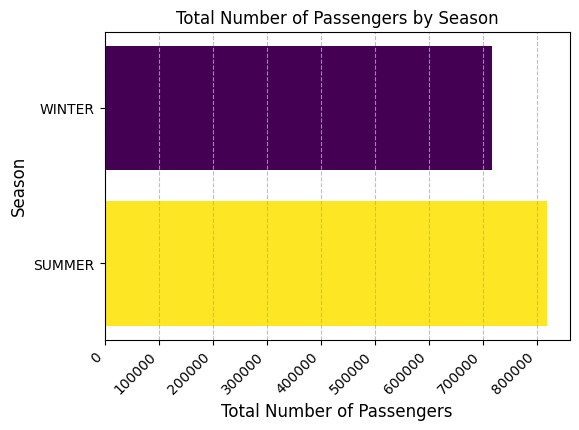

,SEASON,TOTAL_PSGR,AVG_PSGR,TOTAL_FLIGHTS
0,SUMMER,819989,11.902356,68893
1,WINTER,717810,11.601157,61874


In [45]:
import matplotlib.pyplot as plt
import numpy as np

df_current_analysis = df_processed.groupBy("SEASON").agg(
    F.sum("PSGR_COUNT").alias("TOTAL_PSGR"),
    F.mean("PSGR_COUNT").alias("AVG_PSGR"),
    F.count("PSGR_COUNT").alias("TOTAL_FLIGHTS")
).sort(F.desc("TOTAL_PSGR")).limit(5).toPandas()

plt.figure(figsize=(6, 4))
plt.barh(
    df_current_analysis["SEASON"],
    df_current_analysis["TOTAL_PSGR"],
    color=plt.cm.viridis(np.linspace(1, 0, len(df_current_analysis)))
)
plt.grid(True, linestyle="--", alpha=0.8, axis="x")
plt.title("Total Number of Passengers by Season", fontsize=12)
plt.xlabel("Total Number of Passengers", fontsize=12)
plt.ylabel("Season", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.show()

df_current_analysis

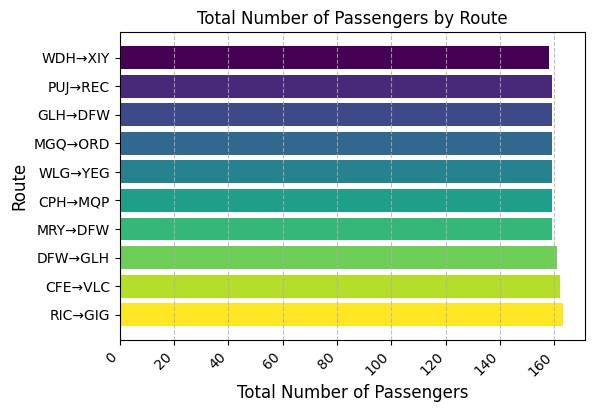

,ROUTE,ORIGIN_CNT_NAME,DEST_CNT_NAME,TOTAL_PSGR,AVG_PSGR,TOTAL_FLIGHTS
0,RIC→GIG,United States,Brazil,163,81.5,2
1,CFE→VLC,France,Spain,162,81.0,2
2,DFW→GLH,United States,United States,161,80.5,2
3,MRY→DFW,United States,United States,159,79.5,2
4,CPH→MQP,Denmark,South Africa,159,79.5,2
5,WLG→YEG,New Zealand,Canada,159,79.5,2
6,MGQ→ORD,Somalia,United States,159,79.5,2
7,GLH→DFW,United States,United States,159,79.5,2
8,PUJ→REC,Dominican Republic,Brazil,159,79.5,2
9,WDH→XIY,Namibia,China,158,79.0,2


In [46]:
import matplotlib.pyplot as plt
import numpy as np

df_current_analysis = df_processed.groupBy(["ROUTE", "ORIGIN_CNT_NAME", "DEST_CNT_NAME"]).agg(
    F.sum("PSGR_COUNT").alias("TOTAL_PSGR"),
    F.mean("PSGR_COUNT").alias("AVG_PSGR"),
    F.count("PSGR_COUNT").alias("TOTAL_FLIGHTS")
).sort(F.desc("TOTAL_PSGR")).limit(10).toPandas()

plt.figure(figsize=(6, 4))
plt.barh(
    df_current_analysis["ROUTE"],
    df_current_analysis["TOTAL_PSGR"],
    color=plt.cm.viridis(np.linspace(1, 0, len(df_current_analysis)))
)
plt.grid(True, linestyle="--", alpha=0.8, axis="x")
plt.title("Total Number of Passengers by Route", fontsize=12)
plt.xlabel("Total Number of Passengers", fontsize=12)
plt.ylabel("Route", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.show()

df_current_analysis

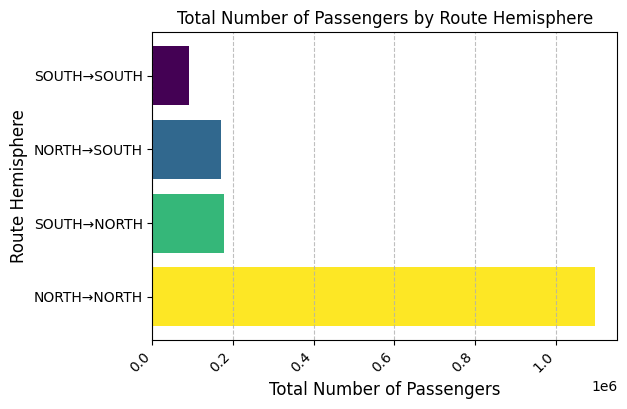

,ROUTE_HEM,TOTAL_PSGR,AVG_PSGR,TOTAL_FLIGHTS
0,NORTH→NORTH,1097659,12.206247,89926
1,SOUTH→NORTH,177938,10.458328,17014
2,NORTH→SOUTH,171151,10.233856,16724
3,SOUTH→SOUTH,91051,12.818668,7103


In [47]:
import matplotlib.pyplot as plt
import numpy as np

df_current_analysis = df_processed.groupBy("ROUTE_HEM").agg(
    F.sum("PSGR_COUNT").alias("TOTAL_PSGR"),
    F.mean("PSGR_COUNT").alias("AVG_PSGR"),
    F.count("PSGR_COUNT").alias("TOTAL_FLIGHTS")
).sort(F.desc("TOTAL_PSGR")).toPandas()

plt.figure(figsize=(6, 4))
plt.barh(
    df_current_analysis["ROUTE_HEM"],
    df_current_analysis["TOTAL_PSGR"],
    color=plt.cm.viridis(np.linspace(1, 0, len(df_current_analysis)))
)
plt.grid(True, linestyle="--", alpha=0.8, axis="x")
plt.title("Total Number of Passengers by Route Hemisphere", fontsize=12)
plt.xlabel("Total Number of Passengers", fontsize=12)
plt.ylabel("Route Hemisphere", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.show()

df_current_analysis

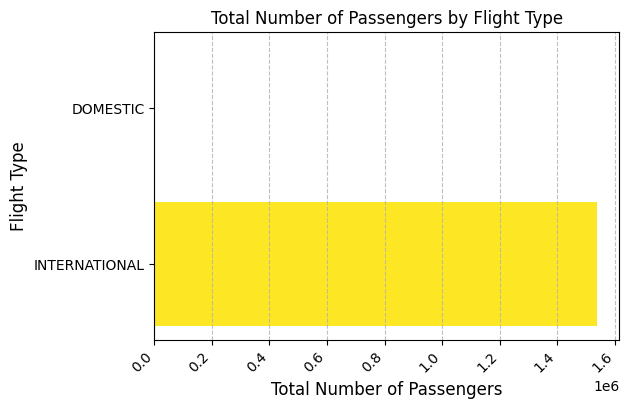

,FLIGHT_TYPE,TOTAL_PSGR,AVG_PSGR,TOTAL_FLIGHTS
0,INTERNATIONAL,1537767,11.761034,130751
1,DOMESTIC,32,2.000000,16


In [48]:
import matplotlib.pyplot as plt
import numpy as np

df_current_analysis = df_processed.groupBy("FLIGHT_TYPE").agg(
    F.sum("PSGR_COUNT").alias("TOTAL_PSGR"),
    F.mean("PSGR_COUNT").alias("AVG_PSGR"),
    F.count("PSGR_COUNT").alias("TOTAL_FLIGHTS")
).sort(F.desc("TOTAL_PSGR")).toPandas()

plt.figure(figsize=(6, 4))
plt.barh(
    df_current_analysis["FLIGHT_TYPE"],
    df_current_analysis["TOTAL_PSGR"],
    color=plt.cm.viridis(np.linspace(1, 0, len(df_current_analysis)))
)
plt.grid(True, linestyle="--", alpha=0.8, axis="x")
plt.title("Total Number of Passengers by Flight Type", fontsize=12)
plt.xlabel("Total Number of Passengers", fontsize=12)
plt.ylabel("Flight Type", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.show()

df_current_analysis

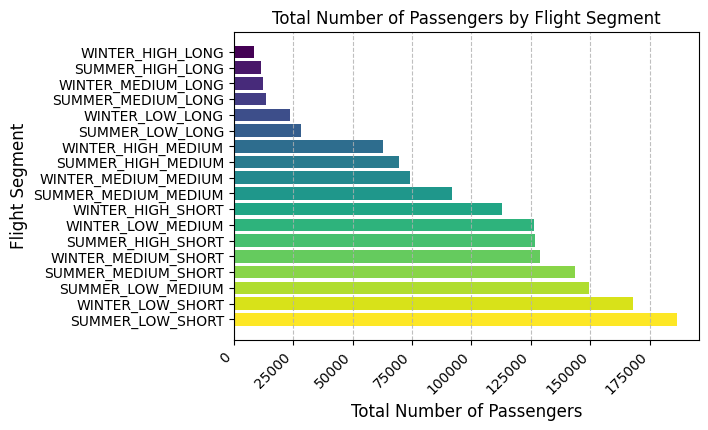

,FLIGHT_SEG,TOTAL_PSGR,AVG_PSGR,TOTAL_FLIGHTS
0,SUMMER_LOW_SHORT,186312,6.508034,28628
1,WINTER_LOW_SHORT,168119,6.384832,26331
2,SUMMER_LOW_MEDIUM,149321,5.841523,25562
3,SUMMER_MEDIUM_SHORT,143460,40.173621,3571
4,WINTER_MEDIUM_SHORT,128707,40.258680,3197
5,SUMMER_HIGH_SHORT,126626,67.859593,1866
6,WINTER_LOW_MEDIUM,126447,5.560310,22741
7,WINTER_HIGH_SHORT,112913,67.856370,1664
8,SUMMER_MEDIUM_MEDIUM,91622,39.922440,2295
9,WINTER_MEDIUM_MEDIUM,74269,39.994076,1857


In [49]:
import matplotlib.pyplot as plt
import numpy as np

df_current_analysis = df_processed.groupBy("FLIGHT_SEG").agg(
    F.sum("PSGR_COUNT").alias("TOTAL_PSGR"),
    F.mean("PSGR_COUNT").alias("AVG_PSGR"),
    F.count("PSGR_COUNT").alias("TOTAL_FLIGHTS")
).sort(F.desc("TOTAL_PSGR")).toPandas()

plt.figure(figsize=(6, 4))
plt.barh(
    df_current_analysis["FLIGHT_SEG"],
    df_current_analysis["TOTAL_PSGR"],
    color=plt.cm.viridis(np.linspace(1, 0, len(df_current_analysis)))
)
plt.grid(True, linestyle="--", alpha=0.8, axis="x")
plt.title("Total Number of Passengers by Flight Segment", fontsize=12)
plt.xlabel("Total Number of Passengers", fontsize=12)
plt.ylabel("Flight Segment", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.show()

df_current_analysis

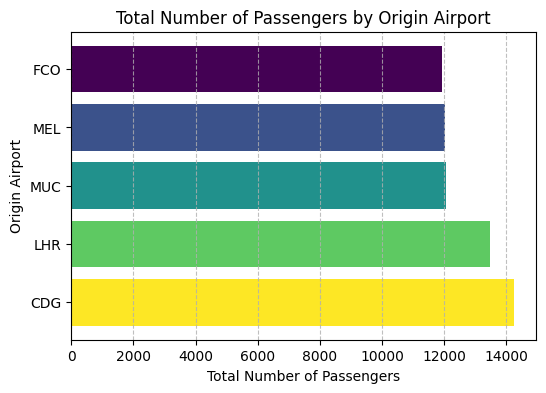

,ORIGIN_AIR_NAME,ORIGIN,TOTAL_PSGR,TOTAL_FLIGHTS
0,Paris Charles de Gaulle Airport,CDG,14245,699
1,Heathrow Airport,LHR,13476,689
2,Munich Airport,MUC,12067,700
3,Melbourne Airport,MEL,12017,696
4,Rome–Fiumicino International Airport,FCO,11928,681


In [51]:
import matplotlib.pyplot as plt
import numpy as np

df_current_analysis = df_processed.groupBy(["ORIGIN_AIR_NAME", "ORIGIN"]).agg(
    F.sum("PSGR_COUNT").alias("TOTAL_PSGR"),
    F.count("PSGR_COUNT").alias("TOTAL_FLIGHTS")
).sort(F.desc("TOTAL_PSGR")).limit(5).toPandas()

plt.figure(figsize=(6, 4))
plt.barh(
    df_current_analysis["ORIGIN"],
    df_current_analysis["TOTAL_PSGR"],
    color=plt.cm.viridis(np.linspace(1, 0, len(df_current_analysis)))
)
plt.grid(True, linestyle="--", alpha=0.8, axis="x")
plt.title("Total Number of Passengers by Origin Airport", fontsize=12)
plt.xlabel("Total Number of Passengers", fontsize=10)
plt.ylabel("Origin Airport", fontsize=10)
plt.show()

df_current_analysis

## Step 5: Clustering

Silhouette Score (k = 2): 0.540584
Silhouette Score (k = 3): 0.635608
Silhouette Score (k = 4): 0.554424
Silhouette Score (k = 5): 0.541166
Silhouette Score (k = 6): 0.833732
Silhouette Score (k = 7): 0.865108
Silhouette Score (k = 8): 0.862533
Silhouette Score (k = 9): 0.907249
Silhouette Score (k = 10): 0.908999


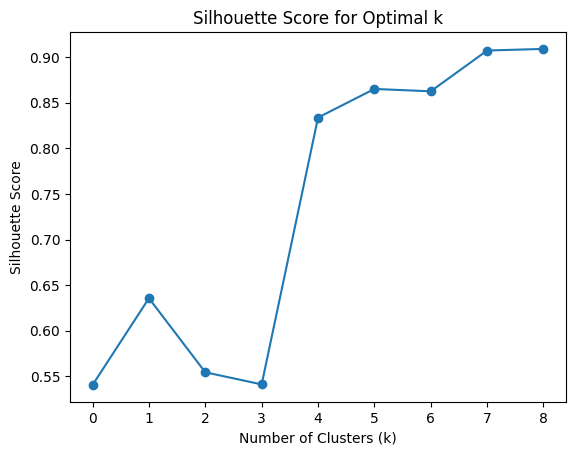

Silhouette Score for Optimal Value: (idx = 10, k = 0.908999)


In [52]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

categorical_cols = ["SEASON", "PSGR_COUNT_CAT", "ROUTE_DST_BKT"]
indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_IDX") for c in categorical_cols]
indexers_pipeline = Pipeline(stages=indexers)
df_indexed = indexers_pipeline.fit(df_processed).transform(df_processed)

feature_cols = [f"{c}_IDX" for c in categorical_cols]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="FEATURES")
df_vectorized = assembler.transform(df_indexed)

scaler = StandardScaler(inputCol="FEATURES", outputCol="SCALED_FEATURES")
df_scaled = scaler.fit(df_vectorized).transform(df_vectorized)

silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(featuresCol="SCALED_FEATURES", k=k, seed=42)
    model = kmeans.fit(df_scaled)
    df_clusters = model.transform(df_scaled)
    
    evaluator = ClusteringEvaluator(featuresCol="SCALED_FEATURES", metricName="silhouette")
    silhouette_score = evaluator.evaluate(df_clusters)
    
    silhouette_scores.append((k, silhouette_score, model, df_clusters))
    print(f"Silhouette Score (k = {k}): {silhouette_score:.6f}")

import matplotlib.pyplot as plt

plt.plot([k[1] for k in silhouette_scores], marker='o', linestyle='-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Optimal k")
plt.show()

opt_idx, opt_k, opt_model, opt_value = max(silhouette_scores, key=lambda k: k[1])
print(f"Silhouette Score for Optimal Value: (idx = {opt_idx}, k = {opt_k:.6f})")

In [53]:
df_clustered = opt_value.select("SEASON", "PSGR_COUNT", "PSGR_COUNT_CAT", "ROUTE", "ROUTE_DST", "ROUTE_DST_BKT", "FLIGHT_SEG", "prediction")
df_clustered.select("prediction").distinct().count()

for idx in range(0, opt_idx):
    df_clustered_filter = df_clustered.filter(F.col("prediction") == idx)
    df_clustered_filter.show(3, truncate=False)
    df_clustered_filter.groupBy("FLIGHT_SEG").count().show()

+------+----------+--------------+-------+------------------+-------------+-----------------+----------+
|SEASON|PSGR_COUNT|PSGR_COUNT_CAT|ROUTE  |ROUTE_DST         |ROUTE_DST_BKT|FLIGHT_SEG       |prediction|
+------+----------+--------------+-------+------------------+-------------+-----------------+----------+
|WINTER|18        |LOW           |CCJ→RIX|6733.018808450966 |MEDIUM       |WINTER_LOW_MEDIUM|0         |
|WINTER|24        |LOW           |CDG→ZLO|9591.378857716612 |MEDIUM       |WINTER_LOW_MEDIUM|0         |
|WINTER|23        |LOW           |CCJ→PHX|14987.660152134564|LONG         |WINTER_LOW_LONG  |0         |
+------+----------+--------------+-------+------------------+-------------+-----------------+----------+
only showing top 3 rows

+-----------------+-----+
|       FLIGHT_SEG|count|
+-----------------+-----+
|WINTER_LOW_MEDIUM|22741|
|  WINTER_LOW_LONG| 4719|
+-----------------+-----+

+------+----------+--------------+-------+-----------------+-------------+---------

## Step 6: Classification

In [54]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

categorical_cols = ["SEASON", "ROUTE_DST_BKT", "ROUTE_HEM"]
indexers = [StringIndexer(inputCol=col, outputCol=col + "_IDX", handleInvalid="keep") for col in categorical_cols]

feature_cols = [col + "_IDX" for col in categorical_cols]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="FEATURES")

label_indexer = StringIndexer(inputCol="FLIGHT_SEG", outputCol="FLIGHT_SEG_LBL", handleInvalid="keep")

train_data, test_data = df_processed.randomSplit([0.8, 0.2], seed=42)

model = RandomForestClassifier(featuresCol="FEATURES", labelCol="FLIGHT_SEG_LBL", predictionCol="FLIGHT_SEG_PRD", numTrees=100, maxBins=200)

accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="FLIGHT_SEG_LBL", predictionCol="FLIGHT_SEG_PRD", metricName="accuracy")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="FLIGHT_SEG_LBL", predictionCol="FLIGHT_SEG_PRD", metricName="f1")

pipeline = Pipeline(stages=indexers + [assembler, label_indexer, model])
trained_model = pipeline.fit(train_data)
predictions = trained_model.transform(test_data)

accuracy = accuracy_evaluator.evaluate(predictions)
f1_score = f1_evaluator.evaluate(predictions)

print(f"Random Forest - Accuracy: {accuracy:.6f}, F1 Score: {f1_score:.6f}")

Random Forest - Accuracy: 0.870175, F1 Score: 0.809939


In [55]:
predictions.sample(False, 0.1).select("SEASON", "ROUTE_DST_BKT", "ROUTE_HEM", "FLIGHT_SEG_LBL", "FLIGHT_SEG_PRD").show(20, truncate=False)

+------+-------------+-----------+--------------+--------------+
|SEASON|ROUTE_DST_BKT|ROUTE_HEM  |FLIGHT_SEG_LBL|FLIGHT_SEG_PRD|
+------+-------------+-----------+--------------+--------------+
|SUMMER|LONG         |NORTH→NORTH|4.0           |4.0           |
|SUMMER|MEDIUM       |NORTH→NORTH|2.0           |2.0           |
|SUMMER|SHORT        |SOUTH→SOUTH|0.0           |0.0           |
|SUMMER|MEDIUM       |SOUTH→NORTH|2.0           |2.0           |
|SUMMER|SHORT        |SOUTH→SOUTH|0.0           |0.0           |
|SUMMER|MEDIUM       |NORTH→NORTH|2.0           |2.0           |
|SUMMER|MEDIUM       |NORTH→SOUTH|2.0           |2.0           |
|SUMMER|MEDIUM       |NORTH→NORTH|12.0          |2.0           |
|SUMMER|SHORT        |NORTH→NORTH|9.0           |0.0           |
|SUMMER|SHORT        |NORTH→NORTH|9.0           |0.0           |
|SUMMER|MEDIUM       |NORTH→SOUTH|8.0           |2.0           |
|SUMMER|MEDIUM       |NORTH→SOUTH|2.0           |2.0           |
|SUMMER|MEDIUM       |NOR

## Conclusion

This study was conducted to process THY flight data using big data technologies, identify flight trends, analyze passenger demand and provide insights for operational improvements.

- **Through data processing and feature engineering**, missing and incorrect data were cleaned, new attributes such as flight distances, flight types, seasonal variations were added.
- **K-Means clustering analysis revealed** that flights were segmented based on seasonal and distance-related characteristics.
- **The classification model (Random Forest) achieved 87% accuracy**, successfully predicting flight segments.
- It was observed that flight demand increased during the summer, **international flights carried the highest number of passengers** and major airports such as **Paris, Munich, Rome served as key hubs**.

This analysis provides valuable insights for optimizing flight routes, improving fleet planning and developing dynamic pricing strategies. In the future, model accuracy can be enhanced by incorporating additional data sources and developing predictive models based on seasonal variations.